In [11]:
# -------------------------------------------------------------
# Step 1: Import necessary libraries
# -------------------------------------------------------------
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import mlflow
import mlflow.sklearn
import yaml
import os
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

mlflow_tracking_uri = 'http://localhost:5555'  # Optional: e.g., 'http://localhost:5555'

sns.set(style="whitegrid")
print("✅ Libraries imported.")

✅ Libraries imported.


In [12]:
# Load your datasets
df_train = pd.read_csv("../data/Training.csv")
df_test = pd.read_csv("../data/Testing.csv")

# Remove any unnamed columns
df_train = df_train.loc[:, ~df_train.columns.str.contains('^Unnamed')]
df_test = df_test.loc[:, ~df_test.columns.str.contains('^Unnamed')]

print(f"Training shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

# Prepare features and target
X_train = df_train.drop('prognosis', axis=1)
y_train = df_train['prognosis']
X_test = df_test.drop('prognosis', axis=1)
y_test = df_test['prognosis']

# Encode target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Classes: {label_encoder.classes_}")

Training shape: (4187, 133)
Test shape: (775, 133)
Number of classes: 41
Classes: ['(vertigo) Paroymsal  Positional Vertigo' 'AIDS' 'Acne'
 'Alcoholic hepatitis' 'Allergy' 'Arthritis' 'Bronchial Asthma'
 'Cervical spondylosis' 'Chicken pox' 'Chronic cholestasis' 'Common Cold'
 'Dengue' 'Diabetes ' 'Dimorphic hemmorhoids(piles)' 'Drug Reaction'
 'Fungal infection' 'GERD' 'Gastroenteritis' 'Heart attack' 'Hepatitis B'
 'Hepatitis C' 'Hepatitis D' 'Hepatitis E' 'Hypertension '
 'Hyperthyroidism' 'Hypoglycemia' 'Hypothyroidism' 'Impetigo' 'Jaundice'
 'Malaria' 'Migraine' 'Osteoarthristis' 'Paralysis (brain hemorrhage)'
 'Peptic ulcer diseae' 'Pneumonia' 'Psoriasis' 'Tuberculosis' 'Typhoid'
 'Urinary tract infection' 'Varicose veins' 'hepatitis A']


In [13]:
print("Starting training...")
# train - CHANGED TO CLASSIFIER
gbm = lgb.LGBMClassifier(
    num_leaves=31, 
    learning_rate=0.05, 
    n_estimators=100,  # Increased for classification
    objective='multiclass',
    num_class=len(label_encoder.classes_),
    random_state=42
)

gbm.fit(
    X_train, 
    y_train_encoded, 
    eval_set=[(X_test, y_test_encoded)], 
    eval_metric="multi_logloss",  # CHANGED METRIC
    callbacks=[lgb.early_stopping(10)]  # Increased patience
)

print("Starting predicting...")
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"The Accuracy of prediction is: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# feature importances
print(f"Number of features: {len(gbm.feature_importances_)}")
print(f"Top 10 feature importances: {list(gbm.feature_importances_[:10])}")

Starting training...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 506
[LightGBM] [Info] Number of data points in the train set: 4187, number of used features: 132
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -3.594808
[LightGBM] [Info] Start training from score -3.648392
[LightGBM] [Info] Start training from score -4.602070
[LightGBM] [Info] Start training from score -3.594808
[LightGBM] [Info] Start training from score -3.648392
[LightGBM] [Info] Start training from score -3.594808
[LightGBM] [Info] Start training from score -4.468539
[LightGBM] [Info] Start training from score -3.594808
[LightGBM] [Info] Start training fr

/home/junaidkhandsi/miniconda3/envs/ddsas_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/junaidkhandsi/miniconda3/envs/ddsas_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/junaidkhandsi/miniconda3/envs/ddsas_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

In [14]:
# Clean feature names first
X_train.columns = X_train.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')

print("Starting training with improved settings...")
gbm = lgb.LGBMClassifier(
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=200,  # Increased
    objective='multiclass',
    num_class=len(label_encoder.classes_),
    random_state=42,
    class_weight='balanced',  # Handle imbalance
    boosting_type='gbdt',
    metric='multi_logloss'
)

gbm.fit(
    X_train, 
    y_train_encoded,
    eval_set=[(X_test, y_test_encoded)],
    eval_metric="multi_logloss",
    callbacks=[
        lgb.early_stopping(20),  # More patience
        lgb.log_evaluation(50)   # Less verbose
    ]
)

# Suppress the precision warnings
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import UndefinedMetricWarning

@ignore_warnings(category=UndefinedMetricWarning)
def safe_classification_report(y_true, y_pred):
    return classification_report(y_true, y_pred, target_names=label_encoder.classes_)

print("Classification Report:")
print(safe_classification_report(y_test_encoded, y_pred))

Starting training with improved settings...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 506
[LightGBM] [Info] Number of data points in the train set: 4187, number of used features: 132
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.713572
[LightGBM]

In [15]:
# Optional MLflow setup
if mlflow_tracking_uri:
    mlflow.set_tracking_uri(mlflow_tracking_uri)
    mlflow.set_experiment("Diesease Prediction Experiment")

2025/11/08 13:18:10 INFO mlflow.tracking.fluent: Experiment with name 'Diesease Prediction Experiment' does not exist. Creating a new experiment.


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define CLASSIFICATION models
models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss'),
    'LightGBM': lgb.LGBMClassifier(random_state=42, class_weight='balanced')  # Your current model
}

# Define hyperparameter grids for CLASSIFICATION
model_grids = {
    'LogisticRegression': {
        'C': [0.1, 1.0, 10.0],           # Regularization strength
        'penalty': ['l2']                 # Type of regularization
    },
    
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'class_weight': ['balanced', None]
    },
    
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 5]
    },
    
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 6, 10],
        'subsample': [0.8, 1.0]
    },
    
    'LightGBM': {
        'num_leaves': [31, 63],
        'learning_rate': [0.1, 0.05],
        'n_estimators': [100, 200],
        'min_data_in_leaf': [20, 50]
    }
}

In [21]:
def evaluate_model_with_gridsearch_classification(name, model, param_grid, X_train, y_train, X_test, y_test):
    """
    Evaluate a model with grid search for CLASSIFICATION problems
    """
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    # Fix for LogisticRegression convergence
    if name == 'LogisticRegression':
        model.max_iter = 5000  # Increase iterations
        # Scale data for Logistic Regression
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        X_train_to_use, X_test_to_use = X_train_scaled, X_test_scaled
    else:
        X_train_to_use, X_test_to_use = X_train, X_test
    
    print(f"🔧 Tuning {name} with grid search...")
    
    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=5,
        scoring='accuracy',  # Use accuracy for classification
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_to_use, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Make predictions
    y_pred = best_model.predict(X_test_to_use)
    
    # Calculate CLASSIFICATION metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"✅ {name} Best CV Score: {grid_search.best_score_:.4f}")
    print(f"   Best Parameters: {best_params}")
    print(f"   Test Accuracy: {accuracy:.4f}")
    
    return {
        'model': best_model,
        'params': best_params,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'best_cv_score': grid_search.best_score_
    }

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
import time
import pandas as pd

print("🎯 Testing LightGBM & Random Forest (Simple Config)...")

results = {}

# Test 1: LightGBM (Simple)
print("\n💡 Testing LightGBM...")
lgb_start = time.time()

lgb_simple = lgb.LGBMClassifier(
    n_estimators=50,           # Reduced for speed
    learning_rate=0.1,
    random_state=42,
    verbose=-1
)

lgb_simple.fit(X_train, y_train_encoded)
y_pred_lgb = lgb_simple.predict(X_test)
lgb_accuracy = accuracy_score(y_test_encoded, y_pred_lgb)
lgb_time = time.time() - lgb_start

results['LightGBM'] = {
    'accuracy': lgb_accuracy,
    'time': lgb_time
}

print(f"✅ LightGBM - Accuracy: {lgb_accuracy:.4f}, Time: {lgb_time:.2f}s")

# Test 2: Random Forest (Simple)
print("\n🌲 Testing Random Forest...")
rf_start = time.time()

rf_simple = RandomForestClassifier(
    n_estimators=50,           # Reduced for speed
    max_depth=10,              # Limited depth
    random_state=42,
    n_jobs=-1
)

rf_simple.fit(X_train, y_train_encoded)
y_pred_rf = rf_simple.predict(X_test)
rf_accuracy = accuracy_score(y_test_encoded, y_pred_rf)
rf_time = time.time() - rf_start

results['RandomForest'] = {
    'accuracy': rf_accuracy, 
    'time': rf_time
}

print(f"✅ Random Forest - Accuracy: {rf_accuracy:.4f}, Time: {rf_time:.2f}s")

# Display Comparison
print("\n📊 QUICK COMPARISON:")
print("=" * 40)
comparison_df = pd.DataFrame([
    {
        'Model': 'LightGBM',
        'Accuracy': results['LightGBM']['accuracy'],
        'Training Time (s)': results['LightGBM']['time']
    },
    {
        'Model': 'RandomForest', 
        'Accuracy': results['RandomForest']['accuracy'],
        'Training Time (s)': results['RandomForest']['time']
    }
]).sort_values('Accuracy', ascending=False)

display(comparison_df)

# Winner
best_model = comparison_df.iloc[0]['Model']
best_accuracy = comparison_df.iloc[0]['Accuracy']
print(f"\n🏆 QUICK WINNER: {best_model} with {best_accuracy:.4f} accuracy!")

🎯 Testing LightGBM & Random Forest (Simple Config)...

💡 Testing LightGBM...
✅ LightGBM - Accuracy: 0.9148, Time: 1.82s

🌲 Testing Random Forest...
✅ Random Forest - Accuracy: 0.5058, Time: 0.23s

📊 QUICK COMPARISON:


,Model,Accuracy,Training Time (s)
0,LightGBM,0.914839,1.820033
1,RandomForest,0.505806,0.234195



🏆 QUICK WINNER: LightGBM with 0.9148 accuracy!


In [ ]:
import dagshub
import mlflow
import pandas as pd
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb

# Initialize DagsHub with YOUR repository
dagshub.init(repo_owner='jkhan2211', repo_name='DiseaseFeatureClassifiers', mlflow=True)

current_branch = "feature/jk-changes"

with mlflow.start_run(run_name=f"My_LightGBM_{current_branch}"):
    mlflow.log_param("git_branch", current_branch)
    mlflow.log_param("assigned_to", "Junaid")

# print("✅ DagsHub MLflow initialized for jkhan2211/DiseaseFeatureClassifiers")
# print(f"📊 Tracking URI: {mlflow.get_tracking_uri()}")

# # Since you're working on a feature branch, let's detect it
# try:
#     import subprocess
#     current_branch = subprocess.run(
#         ['git', 'branch', '--show-current'], 
#         capture_output=True, 
#         text=True, 
#         check=True
#     ).stdout.strip()
# except:
#     # Fallback - you can manually set this
#     current_branch = "feature/jk-changes"  # Change this to your actual branch name

# print(f"🔧 Detected branch: {current_branch}")

# # Set experiment with branch info
# mlflow.set_experiment(f"Disease_Classification_{current_branch}")

# print("🎯 Testing LightGBM & Random Forest with DagsHub MLflow...")

# results = {}

# with mlflow.start_run(run_name=f"Model_Comparison_{current_branch}"):
#     # Log project and branch information
#     mlflow.log_params({
#         "git_branch": current_branch,
#         "feature_owner": "Junaid",
#         "model_assignment": "LightGBM",
#         "project": "DiseaseFeatureClassifiers", 
#         "team": "ML_DSI_Certification",
#         "task": "multi_class_classification",
#         "num_classes": len(np.unique(y_train_encoded)),
#         "num_features": X_train.shape[1],
#         "train_samples": X_train.shape[0],
#         "test_samples": X_test.shape[0],
#     })
    
#     # Test 1: LightGBM 
#     print("\n💡 Testing LightGBM (Your Assigned Model)...")
    
#     with mlflow.start_run(run_name=f"LightGBM_{current_branch}", nested=True):
#         lgb_start = time.time()

#         lgb_simple = lgb.LGBMClassifier(
#             n_estimators=100,
#             learning_rate=0.1,
#             random_state=42,
#             verbose=-1
#         )

#         lgb_simple.fit(X_train, y_train_encoded)
#         y_pred_lgb = lgb_simple.predict(X_test)
        
#         # Calculate metrics
#         lgb_accuracy = accuracy_score(y_test_encoded, y_pred_lgb)
#         lgb_precision = precision_score(y_test_encoded, y_pred_lgb, average='weighted', zero_division=0)
#         lgb_recall = recall_score(y_test_encoded, y_pred_lgb, average='weighted', zero_division=0)
#         lgb_f1 = f1_score(y_test_encoded, y_pred_lgb, average='weighted', zero_division=0)
#         lgb_time = time.time() - lgb_start

#         # Log to DagsHub MLflow
#         mlflow.log_params({
#             "model_type": "LightGBM",
#             "n_estimators": 100,
#             "learning_rate": 0.1,
#             "random_state": 42,
#             "git_branch": current_branch,
#             "assigned_to": "Junaid"
#         })
        
#         mlflow.log_metrics({
#             'accuracy': lgb_accuracy,
#             'precision': lgb_precision,
#             'recall': lgb_recall,
#             'f1_score': lgb_f1,
#             'training_time_seconds': lgb_time
#         })
        
#         # Log the model
#         mlflow.lightgbm.log_model(lgb_simple, "lightgbm_model")
        
#         # Log feature importance
#         if hasattr(lgb_simple, 'feature_importances_'):
#             importance_df = pd.DataFrame({
#                 'feature': X_train.columns,
#                 'importance': lgb_simple.feature_importances_
#             }).sort_values('importance', ascending=False)
            
#             importance_file = "lightgbm_feature_importance.csv"
#             importance_df.to_csv(importance_file, index=False)
#             mlflow.log_artifact(importance_file)
            
#             print(f"📈 LightGBM - Top 3 features:")
#             for i, row in importance_df.head(3).iterrows():
#                 print(f"   {row['feature']}: {row['importance']:.4f}")
        
#         results['LightGBM'] = {
#             'accuracy': lgb_accuracy,
#             'precision': lgb_precision,
#             'recall': lgb_recall,
#             'f1_score': lgb_f1,
#             'time': lgb_time,
#             'model': lgb_simple
#         }

#         print(f"✅ LightGBM - Accuracy: {lgb_accuracy:.4f}, Time: {lgb_time:.2f}s")

#     # Test 2: Random Forest (for comparison)
#     print("\n🌲 Testing Random Forest (Comparison Model)...")
    
#     with mlflow.start_run(run_name=f"RandomForest_{current_branch}", nested=True):
#         rf_start = time.time()

#         rf_simple = RandomForestClassifier(
#             n_estimators=100,
#             max_depth=10,
#             random_state=42,
#             n_jobs=-1
#         )

#         rf_simple.fit(X_train, y_train_encoded)
#         y_pred_rf = rf_simple.predict(X_test)
        
#         # Calculate metrics
#         rf_accuracy = accuracy_score(y_test_encoded, y_pred_rf)
#         rf_precision = precision_score(y_test_encoded, y_pred_rf, average='weighted', zero_division=0)
#         rf_recall = recall_score(y_test_encoded, y_pred_rf, average='weighted', zero_division=0)
#         rf_f1 = f1_score(y_test_encoded, y_pred_rf, average='weighted', zero_division=0)
#         rf_time = time.time() - rf_start

#         # Log to DagsHub MLflow
#         mlflow.log_params({
#             "model_type": "RandomForest",
#             "n_estimators": 100,
#             "max_depth": 10,
#             "random_state": 42,
#             "git_branch": current_branch,
#             "comparison_model": "true"
#         })
        
#         mlflow.log_metrics({
#             'accuracy': rf_accuracy,
#             'precision': rf_precision,
#             'recall': rf_recall,
#             'f1_score': rf_f1,
#             'training_time_seconds': rf_time
#         })
        
#         # Log the model
#         mlflow.sklearn.log_model(rf_simple, "randomforest_model")
        
#         results['RandomForest'] = {
#             'accuracy': rf_accuracy,
#             'precision': rf_precision,
#             'recall': rf_recall,
#             'f1_score': rf_f1,
#             'time': rf_time,
#             'model': rf_simple
#         }

#         print(f"✅ Random Forest - Accuracy: {rf_accuracy:.4f}, Time: {rf_time:.2f}s")

# print("\n✅ DagsHub MLflow tracking complete!")

# # Display Comparison
# print("\n📊 MODEL COMPARISON RESULTS:")
# print("=" * 60)
# comparison_df = pd.DataFrame([
#     {
#         'Model': 'LightGBM',
#         'Accuracy': results['LightGBM']['accuracy'],
#         'Precision': results['LightGBM']['precision'],
#         'Recall': results['LightGBM']['recall'],
#         'F1-Score': results['LightGBM']['f1_score'],
#         'Training Time (s)': results['LightGBM']['time']
#     },
#     {
#         'Model': 'RandomForest',
#         'Accuracy': results['RandomForest']['accuracy'],
#         'Precision': results['RandomForest']['precision'],
#         'Recall': results['RandomForest']['recall'],
#         'F1-Score': results['RandomForest']['f1_score'],
#         'Training Time (s)': results['RandomForest']['time']
#     }
# ]).sort_values('Accuracy', ascending=False)

# display(comparison_df)

# # Winner analysis
# best_model_name = comparison_df.iloc[0]['Model']
# best_accuracy = comparison_df.iloc[0]['Accuracy']
# best_f1 = comparison_df.iloc[0]['F1-Score']

# print(f"\n🏆 BEST MODEL: {best_model_name}")
# print(f"   Accuracy: {best_accuracy:.4f}")
# print(f"   F1-Score: {best_f1:.4f}")

# # Log final summary
# with mlflow.start_run(run_name=f"Final_Summary_{current_branch}"):
#     mlflow.log_params({
#         "best_model": best_model_name,
#         "best_accuracy": best_accuracy,
#         "git_branch": current_branch,
#         "lightgbm_accuracy": results['LightGBM']['accuracy'],
#         "randomforest_accuracy": results['RandomForest']['accuracy']
#     })
#     mlflow.log_metric("winning_accuracy", best_accuracy)

# print(f"\n🌐 VIEW YOUR RESULTS:")
# print(f"   📊 MLflow Dashboard: https://dagshub.com/jkhan2211/DiseaseFeatureClassifiers.mlflow")
# print(f"   📁 Repository: https://dagshub.com/jkhan2211/DiseaseFeatureClassifiers")
# print(f"   🔍 Your experiments are tagged with: git_branch = '{current_branch}'")
# print(f"   👥 Your team can now see your LightGBM results!")

TypeError: init() got an unexpected keyword argument 'current_branch'

📊 Plotting Model Comparison Charts...


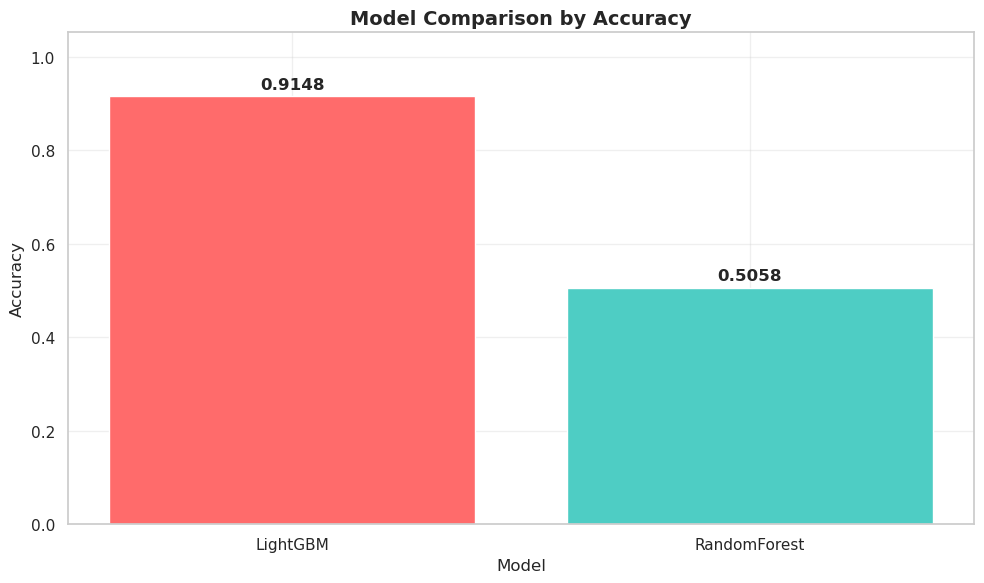

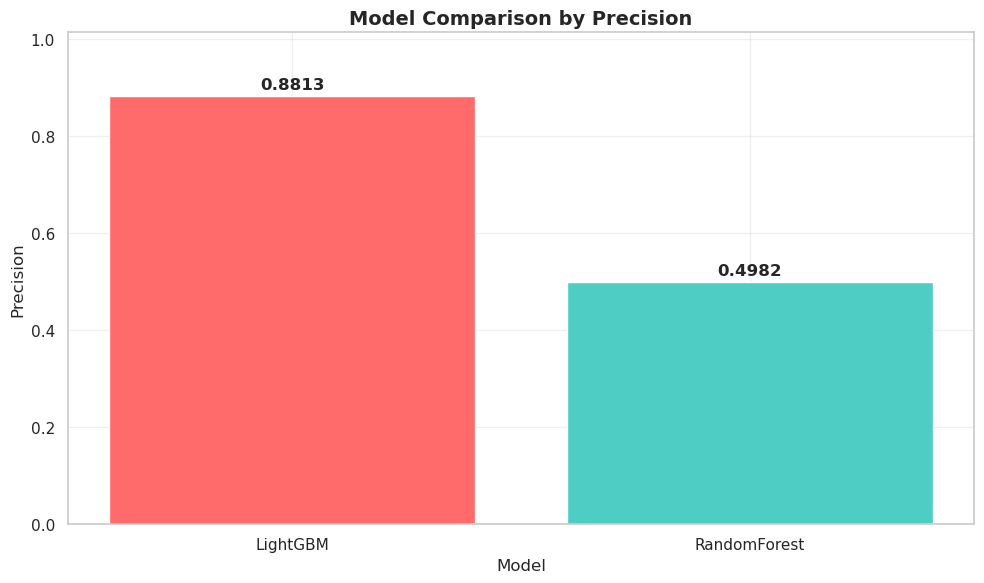

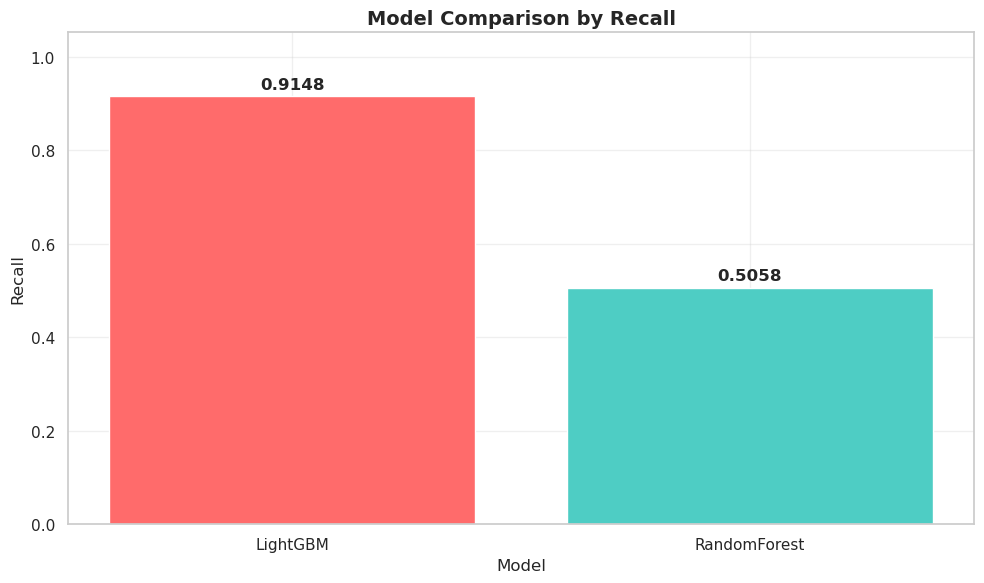

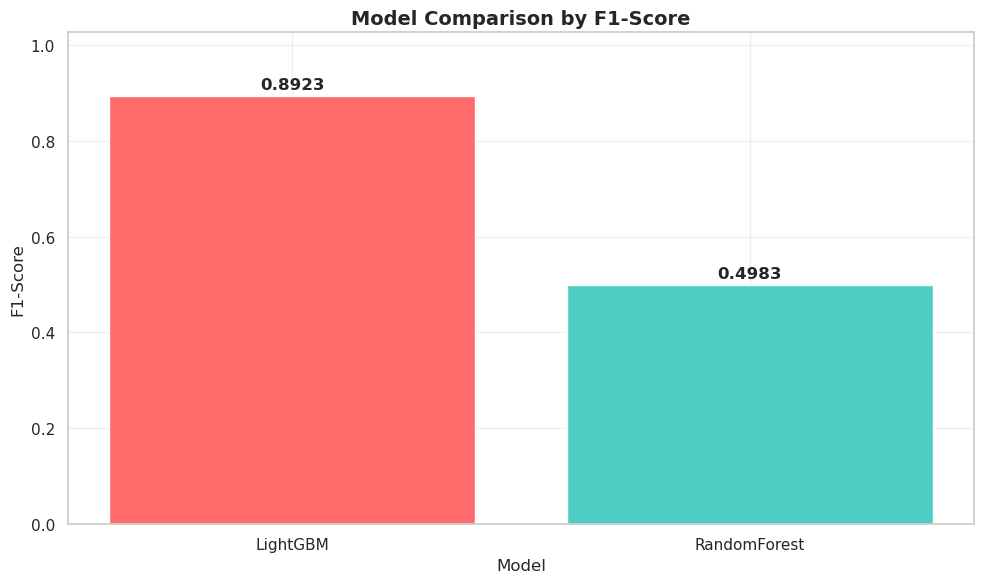

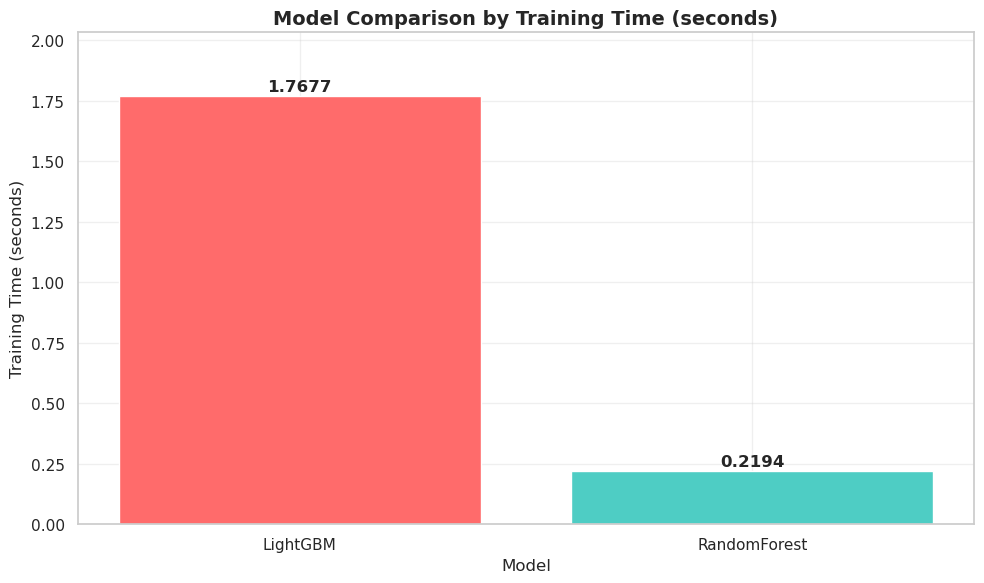

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_model_metrics(results, metric='accuracy'):
    """
    Plot model comparison for classification metrics
    """
    names = list(results.keys())
    
    # Map metric names to display names
    metric_display = {
        'accuracy': 'Accuracy',
        'precision': 'Precision', 
        'recall': 'Recall',
        'f1_score': 'F1-Score',
        'time': 'Training Time (seconds)'
    }
    
    # Get values for the requested metric
    values = [results[name][metric] for name in names]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(names, values, color=['#FF6B6B', '#4ECDC4'])
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.title(f'Model Comparison by {metric_display.get(metric, metric.upper())}', fontsize=14, fontweight='bold')
    plt.xlabel('Model', fontsize=12)
    plt.ylabel(metric_display.get(metric, metric.upper()), fontsize=12)
    plt.ylim(0, max(values) * 1.15)  # Add some headroom for labels
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage with classification metrics:
print("📊 Plotting Model Comparison Charts...")

plot_model_metrics(results, metric='accuracy')
plot_model_metrics(results, metric='precision')
plot_model_metrics(results, metric='recall')
plot_model_metrics(results, metric='f1_score')
plot_model_metrics(results, metric='time')

In [31]:
import yaml
import os

# Display information about the best model
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']
best_params = best_model.get_params()
best_accuracy = float(results[best_model_name]['accuracy'])
best_precision = float(results[best_model_name]['precision'])
best_recall = float(results[best_model_name]['recall'])
best_f1 = float(results[best_model_name]['f1_score'])
best_time = float(results[best_model_name]['time'])

print(f"🏆 Best Model: {best_model_name}")
print(f"   Accuracy: {best_accuracy:.4f}")
print(f"   Precision: {best_precision:.4f}")
print(f"   Recall: {best_recall:.4f}")
print(f"   F1-Score: {best_f1:.4f}")
print(f"   Training Time: {best_time:.2f} seconds")

# Get feature importance if available
feature_importance = {}
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n🔍 Top 5 Most Important Features:")
    for i, row in importance_df.head(5).iterrows():
        print(f"   {row['feature']}: {row['importance']:.4f}")
        feature_importance[row['feature']] = float(row['importance'])

# Create model configuration
model_config = {
    'model': {
        'name': 'disease_classification_model',
        'best_model': best_model_name,
        'model_type': 'classification',
        'parameters': str(best_params),  # Convert to string for YAML compatibility
        'performance_metrics': {
            'accuracy': best_accuracy,
            'precision': best_precision,
            'recall': best_recall,
            'f1_score': best_f1,
            'training_time_seconds': best_time
        },
        'dataset_info': {
            'num_classes': len(np.unique(y_train_encoded)),
            'num_features': X_train.shape[1],
            'train_samples': X_train.shape[0],
            'test_samples': X_test.shape[0],
            'target_variable': 'prognosis'
        },
        'feature_importance': feature_importance,
        'label_encoder_classes': label_encoder.classes_.tolist() if 'label_encoder' in locals() else []
    }
}

# Save configuration
config_path = '../configs/model_config.yaml'
os.makedirs(os.path.dirname(config_path), exist_ok=True)
with open(config_path, 'w') as f:
    yaml.dump(model_config, f, default_flow_style=False)

print(f"\n✅ Saved model config to {config_path}")

# Also save as JSON for easier reading
import json
json_config_path = '../configs/model_config.json'
with open(json_config_path, 'w') as f:
    json.dump(model_config, f, indent=2)

print(f"✅ Saved model config (JSON) to {json_config_path}")

🏆 Best Model: LightGBM
   Accuracy: 0.9148
   Precision: 0.8813
   Recall: 0.9148
   F1-Score: 0.8923
   Training Time: 1.77 seconds

🔍 Top 5 Most Important Features:
   SymptomGroup: 18857.0000
   dark_urine: 1732.0000
   stiff_neck: 1506.0000
   family_history: 1500.0000
   belly_pain: 1464.0000

✅ Saved model config to ../configs/model_config.yaml
✅ Saved model config (JSON) to ../configs/model_config.json
